In [576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.spatial.distance import cdist

In [577]:
warehouses = pd.read_csv('/Users/alexbean/Desktop/data/warehouse_locations.csv')
customers = pd.read_csv('/Users/alexbean/Desktop/data/customer_locations.csv')
supply = pd.read_csv('/Users/alexbean/Desktop/data/supply.csv')
driver = pd.read_csv('/Users/alexbean/Desktop/data/driver_locations.csv')

# Problem 1

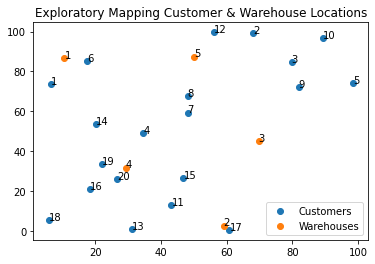

In [578]:
warehouses.columns = ['Warehouse', 'X', 'Y']
customers.columns = ['Customer', 'X', 'Y']
supply.columns = ['Warehouse', 'Supply']
driver.columns = ['Driver', 'X', 'Y']

plt.scatter(customers['X'], customers['Y'], label = 'Customers')
plt.scatter(warehouses['X'], warehouses['Y'], label = 'Warehouses')
plt.title('Exploratory Mapping Customer & Warehouse Locations')
plt.legend()

# Reindexing so the labels are more intuitive
for index, row in customers.iterrows():
    plt.text(row['X'], row['Y'], int(row['Customer']+1))

for index, row in warehouses.iterrows():
    plt.text(row['X'], row['Y'], int(row['Warehouse']+1))

plt.show()

In [579]:
# Creating dictionaries for warehouse, customer, and supply
warehouses = {f'W{i+1:02}': {'coord': np.array([x, y])} for i, (x, y) in enumerate(zip(warehouses['X'], warehouses['Y']))}
customers = {f'C{i+1:02}': {'coord': np.array([x, y])} for i, (x, y) in enumerate(zip(customers['X'], customers['Y']))}
supply = {f'W{i+1:02}': s for i, (s) in enumerate(supply['Supply'])}

# Euclidean distances
distance = {}
for i in warehouses:
    for j in customers:
        distance[i, j] = np.linalg.norm(warehouses[i]['coord'] - customers[j]['coord'])

In [580]:
# Given in instructions as assumption
k = 6

model = gp.Model("DeliveryMinimization")
model.setParam('OutputFlag', 0) # Turn off output

# Variables indicating delivery from warehouse i to customer j
x = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
     for i in warehouses for j in customers}

# Minimize total distance
total_distance = gp.quicksum(distance[i, j] * x[i, j] for i in warehouses for j in customers)
model.setObjective(total_distance, GRB.MINIMIZE)

# Each customer receives at most one delivery
for j in customers:
    model.addConstr(gp.quicksum(x[i, j] for i in warehouses) <= 1, name=f"Customer_{j}_OneDelivery")

# The total number of deliveries is determined by the lesser of the number of drivers or customers
total_deliveries = gp.quicksum(x[i, j] for i in warehouses for j in customers)
max_deliveries = min(k, len(customers))  # choosing between drivers or customers as smallest number
model.addConstr(total_deliveries == max_deliveries, name="TotalDeliveries_Limit")

# Warehouse supply
for i in warehouses:
    model.addConstr(gp.quicksum(x[i, j] for j in customers) <= supply[i], name=f"Warehouse_{i}_Supply")

model.optimize()

if model.status == GRB.OPTIMAL:
    delivery_schedule = []
    total_distance = 0

    for (i, j), var in x.items():
        if var.X > 0.5:  # Check if the variable is selected in the optimal solution
            delivery_info = {
                'warehouse': i,
                'customer': j,
                'distance': distance[i, j],
                'start_coords': warehouses[i]['coord'],
                'end_coords': customers[j]['coord']
            }
            delivery_schedule.append(delivery_info)
            total_distance += distance[i, j]

    print("This yields the following delivery schedule:")
    for idx, delivery in enumerate(delivery_schedule, start=1):
        print(f"Driver {idx} delivers from warehouse {delivery['warehouse']} "
              f"to customer {delivery['customer']}, which is a distance of {delivery['distance']:.1f} units.")
    print(f"With a total distance of {total_distance:.2f} units.")

This yields the following delivery schedule:
Driver 1 delivers from warehouse W01 to customer C01, which is a distance of 13.8 units.
Driver 2 delivers from warehouse W01 to customer C06, which is a distance of 7.1 units.
Driver 3 delivers from warehouse W02 to customer C17, which is a distance of 2.8 units.
Driver 4 delivers from warehouse W04 to customer C19, which is a distance of 7.4 units.
Driver 5 delivers from warehouse W04 to customer C20, which is a distance of 6.2 units.
Driver 6 delivers from warehouse W05 to customer C12, which is a distance of 13.6 units.
With a total distance of 50.91 units.


# Problem 2

The optimal flow is:
Flow from warehouse W01 to customer C01: 1.00 with a distance of 13.83 units.
Flow from warehouse W01 to customer C06: 1.00 with a distance of 7.07 units.
Flow from warehouse W01 to customer C14: 1.00 with a distance of 34.68 units.
Flow from warehouse W02 to customer C11: 1.00 with a distance of 18.82 units.
Flow from warehouse W02 to customer C13: 1.00 with a distance of 27.93 units.
Flow from warehouse W02 to customer C15: 1.00 with a distance of 26.69 units.
Flow from warehouse W02 to customer C17: 1.00 with a distance of 2.82 units.
Flow from warehouse W03 to customer C05: 1.00 with a distance of 40.79 units.
Flow from warehouse W03 to customer C07: 1.00 with a distance of 25.93 units.
Flow from warehouse W03 to customer C09: 1.00 with a distance of 29.82 units.
Flow from warehouse W04 to customer C04: 1.00 with a distance of 18.07 units.
Flow from warehouse W04 to customer C16: 1.00 with a distance of 15.30 units.
Flow from warehouse W04 to customer C18: 1.00

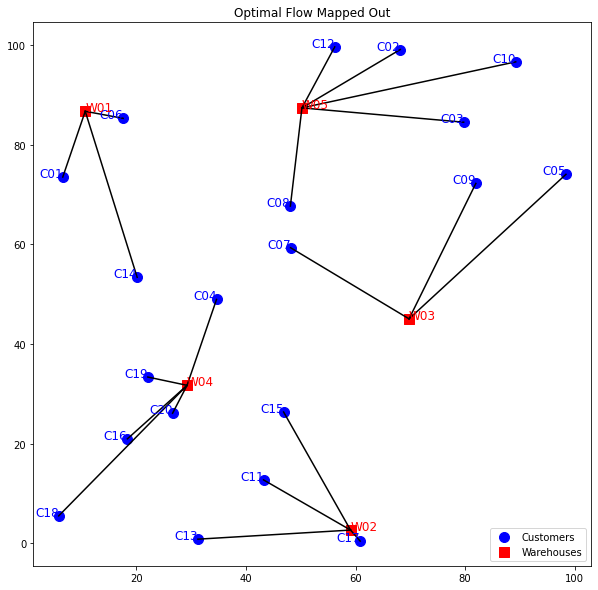

In [581]:
nodes = {**warehouses, **customers}

# Euclidean distances between nodes
distance = {
    (i, j): np.linalg.norm(nodes[i]["coord"] - nodes[j]["coord"])
    for i in nodes for j in customers if i in warehouses or i in customers
}

model = gp.Model("MinimumCostFlow")
model.setParam("OutputFlag", 0) # Turn off output

# y[i, j] is the flow from node i to customer j
y = model.addVars(nodes.keys(), customers.keys(), name = "y", lb = 0, vtype = GRB.INTEGER)

# Minimize the total distance weighted by the flow
model.setObjective(
    gp.quicksum(distance[i, j] * y[i, j] for i, j in distance.keys()), GRB.MINIMIZE
)

# Warehouse constraints
for i in warehouses:
    model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i], name = f"Supply_{i}")

# Flow conservation for customer
for j in customers:
    inf = gp.quicksum(y[i, j] for i in nodes if i != j)
    out = gp.quicksum(y[j, k] for k in customers if k != j)
    model.addConstr(inf - out == 1, name = f"Flow_{j}")

model.optimize()

print("The optimal flow is:")

if model.status == GRB.OPTIMAL:
    flows = {
        (i, j): y[i, j].X
        for i in nodes for j in customers if y[i, j].X > 1e-6 # we picked a threshold of 1e-6 arbitrarily
    }

    for (i, j), flow_value in flows.items():
        if i in warehouses:
            print(f"Flow from warehouse {i} to customer {j}: {flow_value:.2f} with a distance of {distance[i, j]:.2f} units.")
        else:
            print(f"Flow from node {i} to customer {j}: {flow_value:.2f}")
            
    print(f"The total distance of the optimal flow is {model.objVal:.2f} units.")

    plt.figure(figsize=(10, 10))
    plt.scatter(
        [node["coord"][0] for node in customers.values()],
        [node["coord"][1] for node in customers.values()],
        label="Customers", 
        color="blue", 
        marker='o', 
        s=100
    )
    plt.scatter(
        [node["coord"][0] for node in warehouses.values()],
        [node["coord"][1] for node in warehouses.values()],
        label="Warehouses", 
        color="red", 
        marker='s', 
        s=100
    )

    for customer_id, customer_data in customers.items():
        plt.text(
            customer_data["coord"][0], 
            customer_data["coord"][1], 
            f"{customer_id}", 
            fontsize=12, 
            ha='right', 
            color="blue"
        )

    for warehouse_id, warehouse_data in warehouses.items():
        plt.text(
            warehouse_data["coord"][0], 
            warehouse_data["coord"][1], 
            f"{warehouse_id}", 
            fontsize=12, 
            ha='left', 
            color="red"
        )

    plt.title('Customer and Warehouse Locations')

    for (i, j), flow_value in flows.items():
        if flow_value > 1e-6:
            plt.plot(
                [nodes[i]["coord"][0], nodes[j]["coord"][0]],
                [nodes[i]["coord"][1], nodes[j]["coord"][1]],
                color="black"
            )

    plt.title("Optimal Flow Mapped Out")
    plt.legend(loc = "lower right")
    plt.show()

# Problem 3

In [582]:
nodes = {**warehouses, **customers}

distance = {}

for i in warehouses:
    for j in customers:
        distance[i, j] = np.linalg.norm(warehouses[i]['coord'] - customers[j]['coord'])

for i in customers:
    for j in customers:
        distance[i, j] = np.linalg.norm(customers[i]['coord'] - customers[j]['coord'])


In [583]:
model = gp.Model("Problem3")
model.setParam('OutputFlag', 0) # Turn off output

# Maximum number of deliveries per driver
Q = 5

z = model.addVars(distance.keys(), vtype = GRB.BINARY)
y = model.addVars(distance.keys(), lb=0, ub=Q,  vtype = GRB.INTEGER)

model.setObjective(gp.quicksum(distance[i, j] * z[i, j] for i, j in distance.keys()), GRB.MINIMIZE)

for i in warehouses:
    model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i])

for j in customers:
    inflow = gp.quicksum(y[i, j] for i in nodes if i != j)
    outflow = gp.quicksum(y[j, k] for k in customers if k != j)
    model.addConstr(inflow - outflow == 1)

for j in customers:
    model.addConstr(gp.quicksum(z[i, j] for i in nodes if i != j) == 1)

for j in customers:
    model.addConstr(gp.quicksum(z[j, i] for i in customers if i != j) <= 1)

model.addConstr(gp.quicksum(z[i, j] for i in warehouses.keys() for j in customers.keys()) <= k)

for i in nodes:
    for j in customers.keys():
        if i!=j:
            model.addConstr(z[i, j] <= y[i, j])
            model.addConstr(y[i, j] <= Q * z[i, j])

model.optimize()


In [584]:
def get_routes(z_vars, warehouses, customers):
    routes = []
    edges = {i: [] for i in warehouses} 

    for (i, j), var in z_vars.items():
        if var.X > 0.5:
            edges.setdefault(i, []).append(j)

    visited = set()

    for start in warehouses:
        for node in edges[start]:
            if node not in visited:
                route = [start]
                current = node
                route.append(current) 
                visited.add(current) 
                while any(next_node for next_node in edges.get(current, []) if next_node not in visited):
                    for potential_next in edges[current]:
                        if potential_next not in visited:
                            current = potential_next 
                            route.append(current) 
                            visited.add(current)
                            break
                routes.append(route)

    return routes


In [585]:
if model.status == GRB.OPTIMAL:
    delivery_routes = get_routes(z, warehouses, customers)

    for driver_id, route in enumerate(delivery_routes, start=1):
        route_distance = 0
        route_steps = []
        previous_node = None  
    
        for idx in range(len(route) - 1):
            start_node = route[idx]
            end_node = route[idx + 1]
            if end_node == previous_node:
                continue
            distance_between_nodes = distance.get((start_node, end_node), 0)  
            route_distance += distance_between_nodes
            start_label = f"{start_node} -> " if start_node in warehouses else ""
            end_label = f"{end_node}"
            route_steps.append(f"{start_label}{end_label}")
            previous_node = end_node
    
    for driver_id, route in enumerate(delivery_routes, start=1):
        print(f"\nDriver {driver_id}:")
        route_distance = 0
        for idx in range(len(route)-1):
            start_node = route[idx]
            end_node = route[idx+1]
            distance_between_nodes = distance.get((start_node, end_node), 0) 
            route_distance += distance_between_nodes
            if start_node in warehouses:
                start_label = f"Warehouse {start_node}"
            else:
                start_label = f"Customer {start_node}"
            end_label = f"Customer {end_node}"
            print(f"  {start_label} to {end_label}: Distance = {distance_between_nodes:.2f} units.")
        print(f"Total distance for driver {driver_id}: {route_distance:.2f} units.")

    total_distance = sum(distance.get((start_node, end_node), 0) for route in delivery_routes for start_node, end_node in zip(route, route[1:]))
    print(f"Total distance traveled is {total_distance:.2f} units.")


Driver 1:
  Warehouse W01 to Customer C06: Distance = 7.07 units
  Customer C06 to Customer C01: Distance = 16.15 units
Total distance for driver 1: 23.22 units

Driver 2:
  Warehouse W02 to Customer C17: Distance = 2.82 units
  Customer C17 to Customer C15: Distance = 29.46 units
  Customer C15 to Customer C11: Distance = 14.12 units
  Customer C11 to Customer C13: Distance = 16.89 units
Total distance for driver 2: 63.31 units

Driver 3:
  Warehouse W03 to Customer C09: Distance = 29.82 units
  Customer C09 to Customer C03: Distance = 12.50 units
  Customer C03 to Customer C10: Distance = 15.41 units
  Customer C10 to Customer C05: Distance = 24.39 units
Total distance for driver 3: 82.11 units

Driver 4:
  Warehouse W04 to Customer C19: Distance = 7.36 units
  Customer C19 to Customer C20: Distance = 8.56 units
  Customer C20 to Customer C16: Distance = 9.72 units
  Customer C16 to Customer C18: Distance = 19.92 units
Total distance for driver 4: 45.56 units

Driver 5:
  Warehouse 

# Problem 4

In [586]:
def optimal(warehouses, customers, supply, distance, k, Q = 5):
    
    model = gp.Model("Problem3")
    model.setParam('OutputFlag', 0)  # Suppress output
    
    z = model.addVars(distance.keys(), vtype = GRB.BINARY)
    y = model.addVars(distance.keys(), lb = 0, ub = Q,  vtype = GRB.INTEGER)
    
    model.setObjective(gp.quicksum(distance[i, j] * z[i, j] for i, j in distance.keys()), GRB.MINIMIZE)
    
    for i in warehouses:
        model.addConstr(gp.quicksum(y[i, j] for j in customers) <= supply[i])
    
    for j in customers:
        inflow = gp.quicksum(y[i, j] for i in nodes if i != j) 
        outflow = gp.quicksum(y[j, k] for k in customers if k != j)
        model.addConstr(inflow - outflow == 1)
    
    for j in customers:
        model.addConstr(gp.quicksum(z[i, j] for i in nodes if i != j) == 1)
    
    for j in customers:
        model.addConstr(gp.quicksum(z[j, i] for i in customers if i != j) <= 1)
    
    model.addConstr(gp.quicksum(z[i, j] for i in warehouses.keys() for j in customers.keys()) <= k)
    
    for i in nodes:
        for j in customers.keys():
            if i!=j:
                model.addConstr(z[i, j] <= y[i, j])
                model.addConstr(y[i, j] <= Q * z[i, j])
    
    model.optimize()
    return model.objVal

different = {}

for k in range(4, 11):
    different[k] = optimal(warehouses, customers, supply, distance, k)

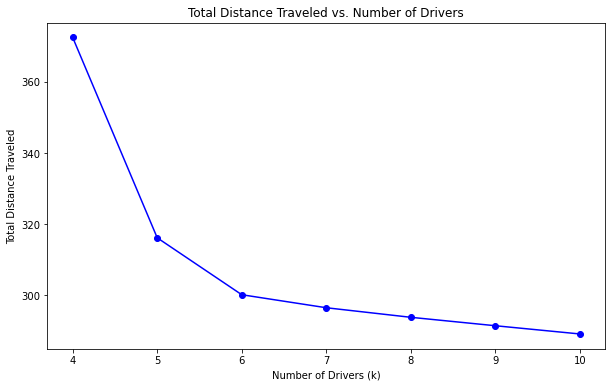

In [589]:
k_values = list(different.keys())
total_distances = list(different.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values, total_distances, marker = 'o', color = 'b', linestyle = '-')
plt.title('Total Distance Traveled vs. Number of Drivers')
plt.xlabel('Number of Drivers (k)')
plt.ylabel('Total Distance Traveled')
plt.show()